# Importing Packages

In [ ]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Loading Dataset

In [106]:
csv_path = r'E:\Assignments\Neural Network\Assignment File\jena_climate_2009_2016.csv'

df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [107]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


# Inspect and Cleanup

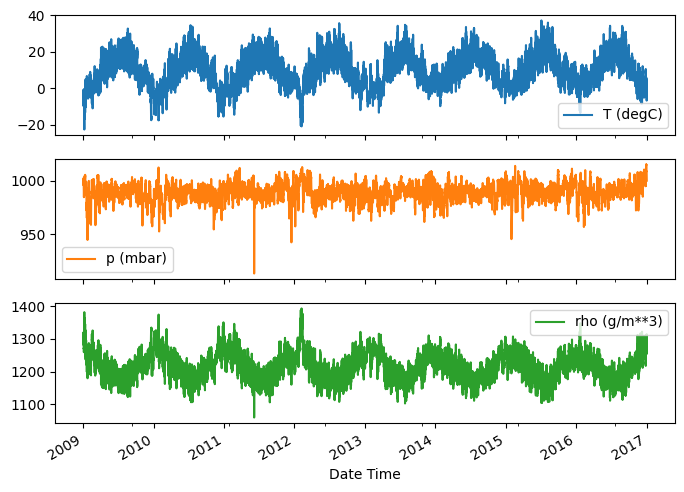

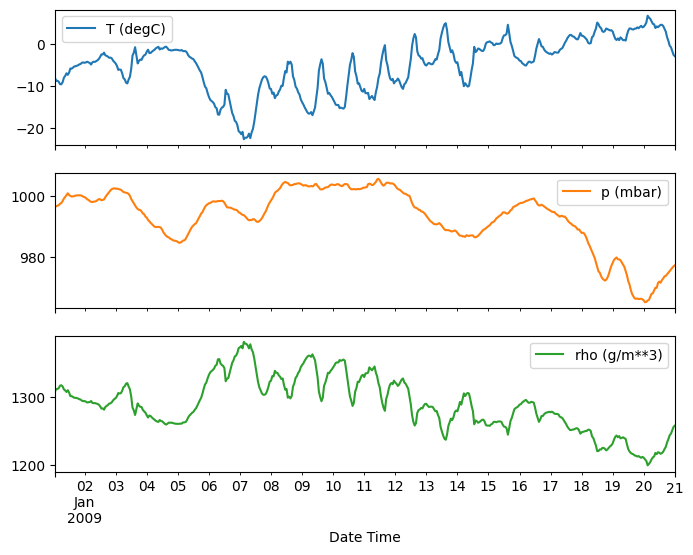

In [108]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [109]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


# Feature Engineering

In [110]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

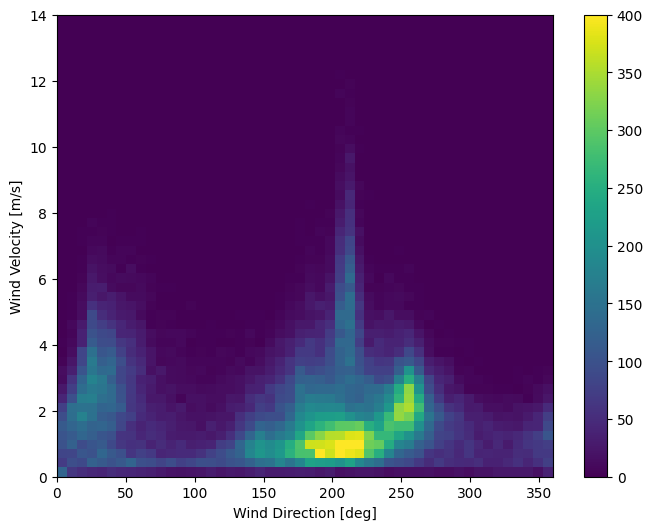

In [111]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [112]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

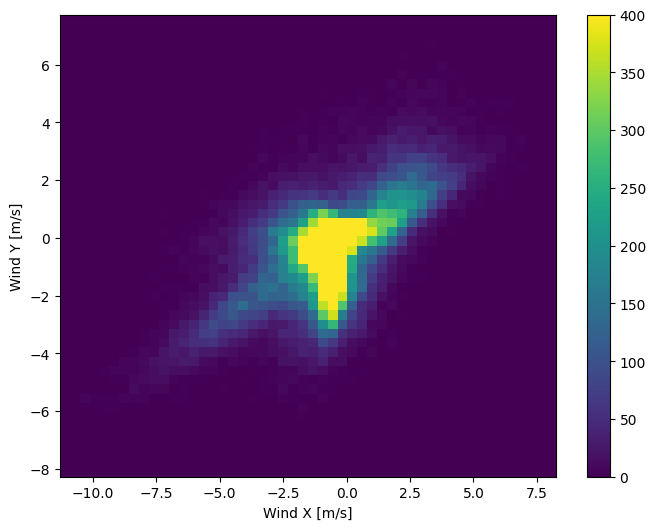

In [113]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [114]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

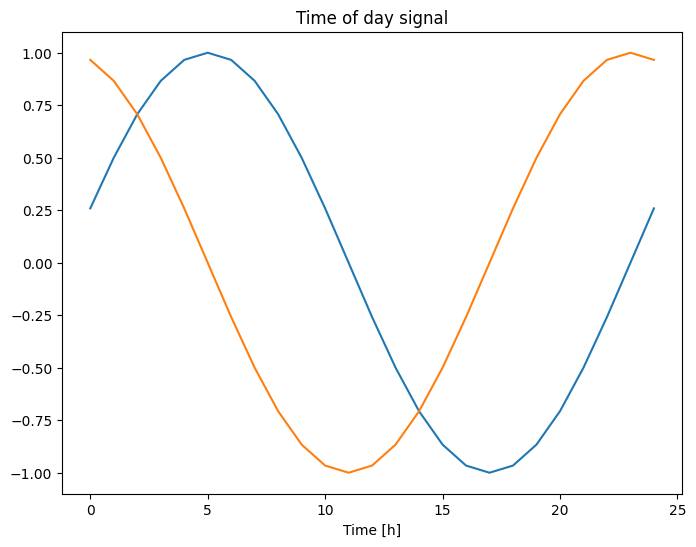

In [115]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

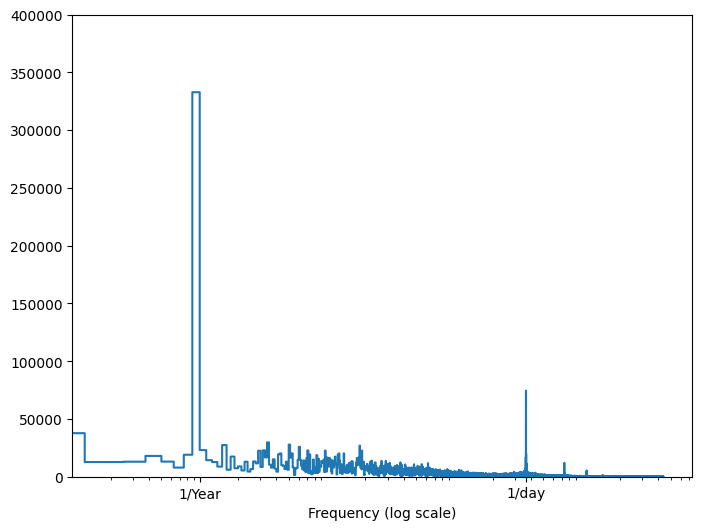

In [116]:
# Convert the Pandas Series to a PyTorch tensor
temperature_data = torch.tensor(df['T (degC)'].values, dtype=torch.float32)

# Perform the real FFT
fft = torch.fft.rfft(temperature_data)

# Create an array of frequency indices
f_per_dataset = torch.arange(0, len(fft))

# Convert back to NumPy if needed
fft_np = fft.numpy()
f_per_dataset = f_per_dataset.numpy()


n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Splitting the Data

In [117]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Normalizing the data

In [118]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

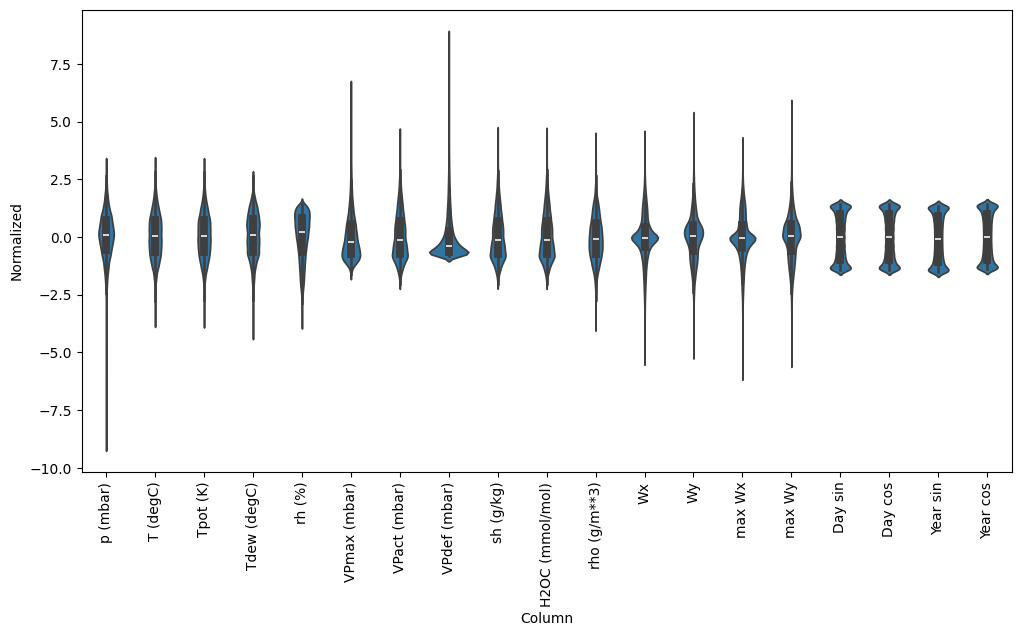

In [119]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing

## PyTroch dataset creation

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, total_window_size, split_window_fn):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.total_window_size = total_window_size
        self.split_window_fn = split_window_fn

    def __len__(self):
        return len(self.data) - self.total_window_size + 1

    def __getitem__(self, idx):
        window = self.data[idx: idx + self.total_window_size]
        return self.split_window_fn(window.unsqueeze(0))


## Indexing, Offseting and Splitting

In [121]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None, batch_size=32):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Store the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.batch_size = batch_size  # New batch_size attribute

        # Define slices for input and label indices.
        self.input_slice = slice(0, input_width)
        self.label_start = self.total_window_size - label_width
        self.labels_slice = slice(self.label_start, None)

        # Store label columns if specified.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    def split_window(self, features):
        """Split the input features into inputs and labels based on window configuration."""
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        
        # Select only the specified label columns if provided.
        if self.label_columns is not None:
            labels = torch.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                dim=-1
            )
        
        # Reshape inputs and labels to ensure compatibility with the model
        inputs = inputs.view(-1, self.input_width, inputs.size(-1))
        labels = labels[:, -1, :]  # Use only the last time step for labels
        return inputs, labels

    def make_dataset(self, data):
        """Convert a DataFrame into a PyTorch DataLoader with the specified batch size."""
        data = np.array(data, dtype=np.float32)
        dataset = TimeSeriesDataset(data, self.total_window_size, self.split_window)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return dataloader

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch for visualization or testing."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_slice}',
            f'Label indices: {self.labels_slice}', 
            f'Label column name(s): {self.label_columns}',
            f'Batch size: {self.batch_size}'
        ])


### creating a window example

In [122]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=['T (degC)'])

w1

Total window size: 48
Input indices: slice(0, 24, None)
Label indices: slice(47, None, None)
Label column name(s): ['T (degC)']
Batch size: 32

### creating a window example with different parameters

In [123]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: slice(0, 6, None)
Label indices: slice(6, None, None)
Label column name(s): ['T (degC)']
Batch size: 32

### checking that the data is being correctly split into segments, each with the expected shape, before passing them to the model.

In [124]:
example_window = torch.stack([
    torch.tensor(train_df[:w2.total_window_size].values, dtype=torch.float32),
    torch.tensor(train_df[100:100 + w2.total_window_size].values, dtype=torch.float32),
    torch.tensor(train_df[200:200 + w2.total_window_size].values, dtype=torch.float32)
])

# Use the split_window function on example_window
example_inputs, example_labels = w2.split_window(example_window)

# Print shapes for verification
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: torch.Size([3, 7, 19])
Inputs shape: torch.Size([3, 6, 19])
Labels shape: torch.Size([3, 1])


In [125]:
example_inputs, example_labels = w2.example
# Print or use the examples as needed
print("Example Inputs:", example_inputs)
print("Example Labels:", example_labels)

Example Inputs: tensor([[[[ 0.2475, -0.7416, -0.7570,  ...,  1.2818,  0.1444,  1.4117],
          [ 0.3246, -0.8109, -0.8315,  ...,  1.3928,  0.1454,  1.4116],
          [ 0.4211, -0.8513, -0.8797,  ...,  1.4089,  0.1464,  1.4114],
          [ 0.4596, -0.9634, -0.9943,  ...,  1.3290,  0.1474,  1.4113],
          [ 0.5560, -1.0015, -1.0390,  ...,  1.1585,  0.1485,  1.4111],
          [ 0.6308, -1.1009, -1.1433,  ...,  0.9091,  0.1495,  1.4110]]],


        [[[ 0.3005,  0.1100,  0.0854,  ...,  0.9091,  1.1487, -0.7001],
          [ 0.2764,  0.0996,  0.0774,  ...,  0.5977,  1.1482, -0.7010],
          [ 0.2511,  0.0534,  0.0327,  ...,  0.2457,  1.1476, -0.7018],
          [ 0.2584,  0.0256,  0.0052,  ..., -0.1231,  1.1471, -0.7027],
          [ 0.2825,  0.0314,  0.0086,  ..., -0.4836,  1.1466, -0.7035],
          [ 0.2933,  0.0406,  0.0166,  ..., -0.8110,  1.1460, -0.7044]]],


        [[[-0.9360,  1.6825,  1.7508,  ..., -1.3288,  1.2238, -0.5592],
          [-1.0155,  1.5854,  1.6614,  .

### Making sure the shape is correct

In [127]:
for example_inputs, example_labels in w2.train:
  print(f'Inputs shape (batch, time, features): {example_inputs.squeeze(1).shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  break

Inputs shape (batch, time, features): torch.Size([32, 6, 19])
Labels shape (batch, time, features): torch.Size([32, 1, 1])


# Model Implementation

### parameters

In [128]:
# Model Parameters
input_size = 19  # Number of features in time series data
hidden_size = 64
output_size = 1  # Predicting a single value
num_layers = 2
epochs = 5
batch_size = 64

### The Window used through the implementation

In [ ]:
# Example instantiation
example_window = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=['T (degC)'],
    batch_size = batch_size
)


### Making sure shape is correct

In [130]:
example_inputs, example_labels = next(iter(example_window.train))
print(f"Input shape: {example_inputs.squeeze(1).shape}")
print(f"Label shape: {example_labels.shape}") 

Input shape: torch.Size([64, 24, 19])
Label shape: torch.Size([64, 1, 1])


## **One Layer Model**

In [131]:
class TimeSeriesForecastingModel_oneLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesForecastingModel_oneLayer, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        out, _ = self.lstm(X)  # LSTM layer
        out = self.linear(out[:, -1, :])  # Take the last time step output
        return out


### Adam Optimizer

In [132]:
# Training parameters
model = TimeSeriesForecastingModel_oneLayer(input_size, hidden_size, output_size)
loss_func_MSE = nn.MSELoss()
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=0.003)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    for inputs, targets in example_window.train:
        inputs = inputs.squeeze(1)
        targets = targets.squeeze(1)
        optimizer_Adam.zero_grad()
        outputs = model(inputs)
        loss = loss_func_MSE(outputs, targets)
        loss.backward()
        optimizer_Adam.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 0.0088
Epoch 2/5, Loss: 0.0046
Epoch 3/5, Loss: 0.0068
Epoch 4/5, Loss: 0.0047
Epoch 5/5, Loss: 0.0067


### SGD Optimizer

In [133]:
# Training parameters
model = TimeSeriesForecastingModel_oneLayer(input_size, hidden_size, output_size)
loss_func_MSE = nn.MSELoss()
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.2)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    for inputs, targets in example_window.train:
        inputs = inputs.squeeze(1)
        targets = targets.squeeze(1)
        optimizer_SGD.zero_grad()
        outputs = model(inputs)
        loss = loss_func_MSE(outputs, targets)
        loss.backward()
        optimizer_SGD.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 0.0039
Epoch 2/5, Loss: 0.0116
Epoch 3/5, Loss: 0.0053
Epoch 4/5, Loss: 0.0022
Epoch 5/5, Loss: 0.0031


## **Two Layers Model**

In [134]:
class TimeSeriesForecastingModel_twoLayer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TimeSeriesForecastingModel_twoLayer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        out, _ = self.lstm(X)  # LSTM layers
        out = self.linear(out[:, -1, :])  # Take the last time step output
        return out

### Adam Optimizer

In [135]:
# Training parameters
model = TimeSeriesForecastingModel_twoLayer(input_size, hidden_size, num_layers, output_size)
loss_func_MSE = nn.MSELoss()
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=0.003)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    for inputs, targets in example_window.train:
        inputs = inputs.squeeze(1)
        targets = targets.squeeze(1)
        optimizer_Adam.zero_grad()
        outputs = model(inputs)
        loss = loss_func_MSE(outputs, targets)
        loss.backward()
        optimizer_Adam.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 0.0048
Epoch 2/5, Loss: 0.0096
Epoch 3/5, Loss: 0.0081
Epoch 4/5, Loss: 0.0045
Epoch 5/5, Loss: 0.0062


### SGD Optimizer

In [136]:
# Training parameters
model = TimeSeriesForecastingModel_twoLayer(input_size, hidden_size, num_layers, output_size)
loss_func_MSE = nn.MSELoss()
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.2)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    for inputs, targets in example_window.train:
        inputs = inputs.squeeze(1)
        targets = targets.squeeze(1)
        optimizer_SGD.zero_grad()
        outputs = model(inputs)
        loss = loss_func_MSE(outputs, targets)
        loss.backward()
        optimizer_SGD.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 0.0066
Epoch 2/5, Loss: 0.0063
Epoch 3/5, Loss: 0.0068
Epoch 4/5, Loss: 0.0095
Epoch 5/5, Loss: 0.0038


## **ReLU Activation Function 2 Layers Model**

In [ ]:
class TimeSeriesForecastingModel_activation(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(TimeSeriesForecastingModel_activation, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.relu = nn.ReLU()  # ReLU activation layer
        self.linear = nn.Linear(hidden_size, output_size)  # Final output layer

    def forward(self, X):
        out, _ = self.lstm(X)  # LSTM layer
        out = self.relu(out[:, -1, :])  # Apply ReLU to the last time step's output
        out = self.linear(out)  # Final output layer
        return out


### Adam Optimizer

In [154]:
# Training parameters
model = TimeSeriesForecastingModel_activation(input_size, hidden_size, num_layers, output_size)
loss_func_MSE = nn.MSELoss()
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=0.003)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    for inputs, targets in example_window.train:
        inputs = inputs.squeeze(1)
        targets = targets.squeeze(1)
        optimizer_Adam.zero_grad()
        outputs = model(inputs)
        loss = loss_func_MSE(outputs, targets)
        loss.backward()
        optimizer_Adam.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 0.0093
Epoch 2/5, Loss: 0.0036
Epoch 3/5, Loss: 0.0074
Epoch 4/5, Loss: 0.0013
Epoch 5/5, Loss: 0.0135


### SGD Optimizer

In [155]:
# Training parameters
model = TimeSeriesForecastingModel_activation(input_size, hidden_size, num_layers, output_size)
loss_func_MSE = nn.MSELoss()
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.2)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    for inputs, targets in example_window.train:
        inputs = inputs.squeeze(1)
        targets = targets.squeeze(1)
        optimizer_SGD.zero_grad()
        outputs = model(inputs)
        loss = loss_func_MSE(outputs, targets)
        loss.backward()
        optimizer_SGD.step()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 0.0055
Epoch 2/5, Loss: 0.0039
Epoch 3/5, Loss: 0.0065
Epoch 4/5, Loss: 0.0047
Epoch 5/5, Loss: 0.0097


# Chose best model to try test and validation sets on

In [ ]:
from tqdm import tqdm
# Define model, loss function, and optimizer
model = TimeSeriesForecastingModel_activation(input_size, hidden_size, num_layers, output_size)
loss_func = nn.MSELoss()  # Use MSE for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# List of data loaders for train, test, and validation sets
train_test_val_list = [example_window.train, example_window.test, example_window.val]

# Iterate over each data loader (train, test, val) with its index
for idx, data_loader in enumerate(train_test_val_list):
    # Determine the name for printing based on index
    data_loader_name = "Train" if idx == 0 else "Test" if idx == 1 else "Validation"

    for epoch in range(epochs):
        model.train()
        
        # Initialize tqdm progress bar for the current epoch
        pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{epochs}")

        for inputs, targets in pbar:
            # Ensure correct input shape
            inputs = inputs.squeeze(1)
            targets = targets.squeeze(1)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update progress bar with current loss
            pbar.set_postfix({"Loss": loss.item()})

        # Print loss summary after each epoch
        print(f"The {data_loader_name} Loss after epoch {epoch + 1}: {loss.item():.4f}")


Epoch 1/5: 100%|██████████| 767/767 [00:09<00:00, 77.99it/s, Loss=0.00507]


The Train Loss after epoch 1: 0.0051


Epoch 2/5: 100%|██████████| 767/767 [00:10<00:00, 74.30it/s, Loss=0.00536]


The Train Loss after epoch 2: 0.0054


Epoch 3/5: 100%|██████████| 767/767 [00:11<00:00, 64.73it/s, Loss=0.0113] 


The Train Loss after epoch 3: 0.0113


Epoch 4/5: 100%|██████████| 767/767 [00:12<00:00, 59.63it/s, Loss=0.0155] 


The Train Loss after epoch 4: 0.0155


Epoch 5/5: 100%|██████████| 767/767 [00:14<00:00, 54.49it/s, Loss=0.0073] 


The Train Loss after epoch 5: 0.0073


Epoch 1/5: 100%|██████████| 110/110 [00:01<00:00, 58.28it/s, Loss=0.00821]


The Test Loss after epoch 1: 0.0082


Epoch 2/5: 100%|██████████| 110/110 [00:01<00:00, 56.69it/s, Loss=0.0056] 


The Test Loss after epoch 2: 0.0056


Epoch 3/5: 100%|██████████| 110/110 [00:01<00:00, 61.36it/s, Loss=0.00162]


The Test Loss after epoch 3: 0.0016


Epoch 4/5: 100%|██████████| 110/110 [00:01<00:00, 58.70it/s, Loss=0.00924]


The Test Loss after epoch 4: 0.0092


Epoch 5/5: 100%|██████████| 110/110 [00:01<00:00, 58.32it/s, Loss=0.00139]


The Test Loss after epoch 5: 0.0014


Epoch 1/5: 100%|██████████| 219/219 [00:03<00:00, 57.11it/s, Loss=0.00342]


The Validation Loss after epoch 1: 0.0034


Epoch 2/5: 100%|██████████| 219/219 [00:03<00:00, 56.55it/s, Loss=0.00333]


The Validation Loss after epoch 2: 0.0033


Epoch 3/5: 100%|██████████| 219/219 [00:04<00:00, 50.25it/s, Loss=0.00356]


The Validation Loss after epoch 3: 0.0036


Epoch 4/5: 100%|██████████| 219/219 [00:04<00:00, 48.82it/s, Loss=0.00438]


The Validation Loss after epoch 4: 0.0044


Epoch 5/5: 100%|██████████| 219/219 [00:04<00:00, 51.76it/s, Loss=0.00511]

The Validation Loss after epoch 5: 0.0051


## Trying Different Parameters and Plotting The results

### Different batch sizes, learning rates, layers of the model

Parameter Combinations:  12%|█▎        | 1/8 [00:37<04:25, 37.99s/it]

Batch Size: 64, Learning Rate: 0.001, Layers: 2, Avg Loss: 0.8990


Parameter Combinations:  25%|██▌       | 2/8 [01:45<05:30, 55.15s/it]

Batch Size: 64, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.8988


Parameter Combinations:  38%|███▊      | 3/8 [02:33<04:20, 52.01s/it]

Batch Size: 64, Learning Rate: 0.05, Layers: 2, Avg Loss: 0.9008


Parameter Combinations:  50%|█████     | 4/8 [03:47<04:03, 60.81s/it]

Batch Size: 64, Learning Rate: 0.05, Layers: 3, Avg Loss: 0.9027


Parameter Combinations:  62%|██████▎   | 5/8 [04:25<02:37, 52.48s/it]

Batch Size: 128, Learning Rate: 0.001, Layers: 2, Avg Loss: 0.8994


Parameter Combinations:  75%|███████▌  | 6/8 [05:21<01:47, 53.58s/it]

Batch Size: 128, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.9006


Parameter Combinations:  88%|████████▊ | 7/8 [06:13<00:53, 53.33s/it]

Batch Size: 128, Learning Rate: 0.05, Layers: 2, Avg Loss: 0.9015


Parameter Combinations: 100%|██████████| 8/8 [07:38<00:00, 57.29s/it]

Batch Size: 128, Learning Rate: 0.05, Layers: 3, Avg Loss: 0.9030


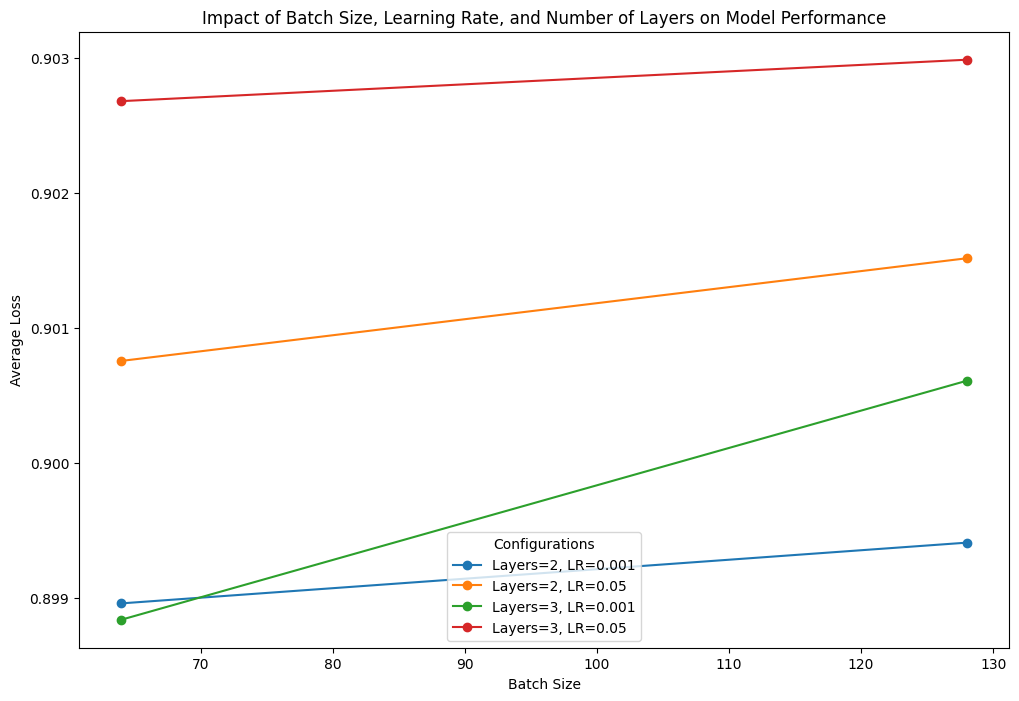

In [ ]:
from tqdm import tqdm
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters to test
batch_sizes = [64, 128]
learning_rates = [0.001, 0.05]
number_of_layers = [2, 3]
results = []

# Total number of combinations
total_combinations = len(batch_sizes) * len(learning_rates) * len(number_of_layers)

# Outer loop with tqdm for monitoring progress
for batch_size, lr, layers in tqdm(product(batch_sizes, learning_rates, number_of_layers), total=total_combinations, desc="Parameter Combinations"):
    
    # Set up the model and optimizer with current parameters
    model = TimeSeriesForecastingModel_activation(input_size=19, hidden_size=64, num_layers=layers, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = nn.MSELoss()
    
    # Train the model and record final loss
    epoch_loss = 0
    for epoch in range(2):  # Fewer epochs for quick experimentation
        model.train()
        batch_loss = 0
        
        # Create DataLoader with current batch size
        data_loader = WindowGenerator(
            input_width=24,
            label_width=1,
            shift=1,
            train_df=train_df,
            val_df=val_df,
            test_df=test_df,
            batch_size=batch_size
        ).train
        
        for inputs, targets in data_loader:
            inputs = inputs.squeeze(1)
            targets = targets.squeeze(1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            
            batch_loss += loss.item()
        
        # Calculate average loss for the epoch
        epoch_loss += batch_loss / len(data_loader)
    
    # Average loss over all epochs for current parameters
    avg_loss = epoch_loss / 2
    results.append({'batch_size': batch_size, 'learning_rate': lr, 'number_of_layers': layers, 'avg_loss': avg_loss})
    
    # Print progress for each parameter combination
    print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Layers: {layers}, Avg Loss: {avg_loss:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting results
plt.figure(figsize=(12, 8))
for layers in number_of_layers:
    subset = results_df[results_df['number_of_layers'] == layers]
    for lr in learning_rates:
        subset_lr = subset[subset['learning_rate'] == lr]
        plt.plot(subset_lr['batch_size'], subset_lr['avg_loss'], marker='o', label=f'Layers={layers}, LR={lr}')
        
plt.xlabel('Batch Size')
plt.ylabel('Average Loss')
plt.title('Impact of Batch Size, Learning Rate, and Number of Layers on Model Performance')
plt.legend(title='Configurations')
plt.show()


### It was divied into two part just not to take long time

Parameter Combinations:  12%|█▎        | 1/8 [01:08<07:56, 68.00s/it]

Batch Size: 256, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.8995


Parameter Combinations:  25%|██▌       | 2/8 [02:45<08:30, 85.09s/it]

Batch Size: 256, Learning Rate: 0.001, Layers: 4, Avg Loss: 0.9001


Parameter Combinations:  38%|███▊      | 3/8 [03:57<06:35, 79.18s/it]

Batch Size: 256, Learning Rate: 0.01, Layers: 3, Avg Loss: 0.8981


Parameter Combinations:  50%|█████     | 4/8 [05:33<05:43, 85.82s/it]

Batch Size: 256, Learning Rate: 0.01, Layers: 4, Avg Loss: 0.8985


Parameter Combinations:  62%|██████▎   | 5/8 [06:35<03:51, 77.20s/it]

Batch Size: 512, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.9019


Parameter Combinations:  75%|███████▌  | 6/8 [07:56<02:37, 78.75s/it]

Batch Size: 512, Learning Rate: 0.001, Layers: 4, Avg Loss: 0.9019


Parameter Combinations:  88%|████████▊ | 7/8 [09:01<01:14, 74.28s/it]

Batch Size: 512, Learning Rate: 0.01, Layers: 3, Avg Loss: 0.8988


Parameter Combinations: 100%|██████████| 8/8 [10:26<00:00, 78.33s/it]

Batch Size: 512, Learning Rate: 0.01, Layers: 4, Avg Loss: 0.8991


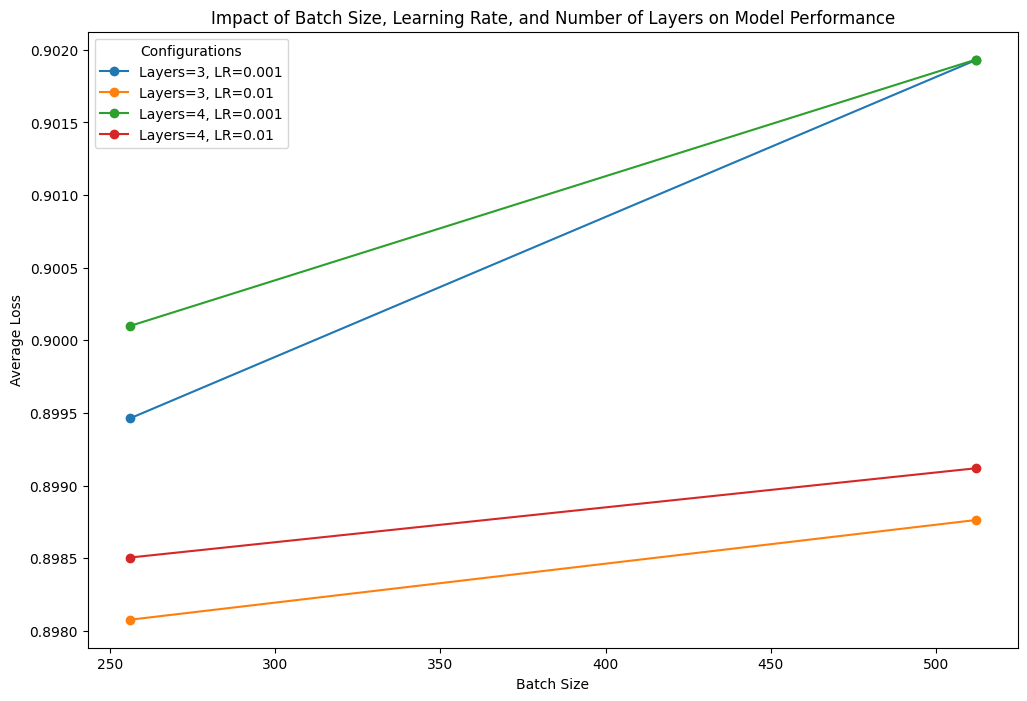

In [ ]:
from tqdm import tqdm
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters to test
batch_sizes = [256, 512]
learning_rates = [0.001, 0.01]
number_of_layers = [3, 4]
results = []

# Total number of combinations
total_combinations = len(batch_sizes) * len(learning_rates) * len(number_of_layers)

# Outer loop with tqdm for monitoring progress
for batch_size, lr, layers in tqdm(product(batch_sizes, learning_rates, number_of_layers), total=total_combinations, desc="Parameter Combinations"):
    
    # Set up the model and optimizer with current parameters
    model = TimeSeriesForecastingModel_activation(input_size=19, hidden_size=64, num_layers=layers, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = nn.MSELoss()
    
    # Train the model and record final loss
    epoch_losses = []  # Store loss for each epoch

    for epoch in range(5):  # Fewer epochs for quick experimentation
        model.train()
        batch_loss_sum = 0
        
        # Create DataLoader with current batch size
        data_loader = WindowGenerator(
            input_width=24,
            label_width=1,
            shift=1,
            train_df=train_df,
            val_df=val_df,
            test_df=test_df,
            batch_size=batch_size
        ).train
        
        for inputs, targets in data_loader:
            inputs = inputs.squeeze(1)
            targets = targets.squeeze(1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            
            batch_loss_sum += loss.item()
        
        # Calculate and store average loss for this epoch
        epoch_loss = batch_loss_sum / len(data_loader)
        epoch_losses.append(epoch_loss)
    
    # Average loss across epochs for current parameters
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    results.append({'batch_size': batch_size, 'learning_rate': lr, 'number_of_layers': layers, 'avg_loss': avg_loss})
    
    # Print progress for each parameter combination
    print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Layers: {layers}, Avg Loss: {avg_loss:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting results
plt.figure(figsize=(12, 8))
for layers in number_of_layers:
    subset = results_df[results_df['number_of_layers'] == layers]
    for lr in learning_rates:
        subset_lr = subset[subset['learning_rate'] == lr]
        plt.plot(subset_lr['batch_size'], subset_lr['avg_loss'], marker='o', label=f'Layers={layers}, LR={lr}')
        
plt.xlabel('Batch Size')
plt.ylabel('Average Loss')
plt.title('Impact of Batch Size, Learning Rate, and Number of Layers on Model Performance')
plt.legend(title='Configurations')
plt.show()


### Using Validation Set

Parameter Combinations:   2%|▏         | 1/64 [00:10<11:25, 10.89s/it]

Batch Size: 64, Learning Rate: 0.001, Layers: 2, Avg Loss: 0.8908


Parameter Combinations:   3%|▎         | 2/64 [00:31<17:02, 16.50s/it]

Batch Size: 64, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.8929


Parameter Combinations:   5%|▍         | 3/64 [00:57<21:29, 21.14s/it]

Batch Size: 64, Learning Rate: 0.001, Layers: 4, Avg Loss: 0.8942


Parameter Combinations:   6%|▋         | 4/64 [01:32<26:15, 26.25s/it]

Batch Size: 64, Learning Rate: 0.001, Layers: 5, Avg Loss: 0.8971


Parameter Combinations:   8%|▊         | 5/64 [01:48<22:23, 22.78s/it]

Batch Size: 64, Learning Rate: 0.01, Layers: 2, Avg Loss: 0.8900


Parameter Combinations:   9%|▉         | 6/64 [02:13<22:40, 23.46s/it]

Batch Size: 64, Learning Rate: 0.01, Layers: 3, Avg Loss: 0.8896


Parameter Combinations:  11%|█         | 7/64 [02:48<25:47, 27.14s/it]

Batch Size: 64, Learning Rate: 0.01, Layers: 4, Avg Loss: 0.8917


Parameter Combinations:  12%|█▎        | 8/64 [03:25<28:17, 30.30s/it]

Batch Size: 64, Learning Rate: 0.01, Layers: 5, Avg Loss: 0.8917


Parameter Combinations:  14%|█▍        | 9/64 [03:41<23:52, 26.05s/it]

Batch Size: 64, Learning Rate: 0.005, Layers: 2, Avg Loss: 0.8908


Parameter Combinations:  16%|█▌        | 10/64 [04:04<22:24, 24.89s/it]

Batch Size: 64, Learning Rate: 0.005, Layers: 3, Avg Loss: 0.8889


Parameter Combinations:  17%|█▋        | 11/64 [04:32<22:54, 25.93s/it]

Batch Size: 64, Learning Rate: 0.005, Layers: 4, Avg Loss: 0.8918


Parameter Combinations:  19%|█▉        | 12/64 [05:05<24:22, 28.12s/it]

Batch Size: 64, Learning Rate: 0.005, Layers: 5, Avg Loss: 0.8913


Parameter Combinations:  20%|██        | 13/64 [05:20<20:23, 23.99s/it]

Batch Size: 64, Learning Rate: 0.05, Layers: 2, Avg Loss: 0.9034


Parameter Combinations:  22%|██▏       | 14/64 [05:41<19:12, 23.05s/it]

Batch Size: 64, Learning Rate: 0.05, Layers: 3, Avg Loss: 0.9016


Parameter Combinations:  23%|██▎       | 15/64 [06:08<19:59, 24.49s/it]

Batch Size: 64, Learning Rate: 0.05, Layers: 4, Avg Loss: 0.9135


Parameter Combinations:  25%|██▌       | 16/64 [06:48<23:17, 29.11s/it]

Batch Size: 64, Learning Rate: 0.05, Layers: 5, Avg Loss: 0.9199


Parameter Combinations:  27%|██▋       | 17/64 [07:01<18:54, 24.14s/it]

Batch Size: 128, Learning Rate: 0.001, Layers: 2, Avg Loss: 0.8941


Parameter Combinations:  28%|██▊       | 18/64 [07:21<17:40, 23.05s/it]

Batch Size: 128, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.8945


Parameter Combinations:  30%|██▉       | 19/64 [07:43<17:01, 22.70s/it]

Batch Size: 128, Learning Rate: 0.001, Layers: 4, Avg Loss: 0.8983


Parameter Combinations:  31%|███▏      | 20/64 [08:07<16:53, 23.03s/it]

Batch Size: 128, Learning Rate: 0.001, Layers: 5, Avg Loss: 0.8999


Parameter Combinations:  33%|███▎      | 21/64 [08:18<13:57, 19.48s/it]

Batch Size: 128, Learning Rate: 0.01, Layers: 2, Avg Loss: 0.8906


Parameter Combinations:  34%|███▍      | 22/64 [08:34<12:46, 18.26s/it]

Batch Size: 128, Learning Rate: 0.01, Layers: 3, Avg Loss: 0.8919


Parameter Combinations:  36%|███▌      | 23/64 [08:53<12:40, 18.54s/it]

Batch Size: 128, Learning Rate: 0.01, Layers: 4, Avg Loss: 0.8936


Parameter Combinations:  38%|███▊      | 24/64 [09:16<13:20, 20.01s/it]

Batch Size: 128, Learning Rate: 0.01, Layers: 5, Avg Loss: 0.8938


Parameter Combinations:  39%|███▉      | 25/64 [09:26<11:03, 17.01s/it]

Batch Size: 128, Learning Rate: 0.005, Layers: 2, Avg Loss: 0.8901


Parameter Combinations:  41%|████      | 26/64 [09:41<10:19, 16.31s/it]

Batch Size: 128, Learning Rate: 0.005, Layers: 3, Avg Loss: 0.8907


Parameter Combinations:  42%|████▏     | 27/64 [10:00<10:29, 17.01s/it]

Batch Size: 128, Learning Rate: 0.005, Layers: 4, Avg Loss: 0.8925


Parameter Combinations:  44%|████▍     | 28/64 [10:24<11:32, 19.24s/it]

Batch Size: 128, Learning Rate: 0.005, Layers: 5, Avg Loss: 0.8939


Parameter Combinations:  45%|████▌     | 29/64 [10:34<09:41, 16.61s/it]

Batch Size: 128, Learning Rate: 0.05, Layers: 2, Avg Loss: 0.8991


Parameter Combinations:  47%|████▋     | 30/64 [10:49<09:03, 15.99s/it]

Batch Size: 128, Learning Rate: 0.05, Layers: 3, Avg Loss: 0.9075


Parameter Combinations:  48%|████▊     | 31/64 [11:08<09:22, 17.03s/it]

Batch Size: 128, Learning Rate: 0.05, Layers: 4, Avg Loss: 0.9094


Parameter Combinations:  50%|█████     | 32/64 [11:33<10:17, 19.29s/it]

Batch Size: 128, Learning Rate: 0.05, Layers: 5, Avg Loss: 0.9501


Parameter Combinations:  52%|█████▏    | 33/64 [11:41<08:08, 15.76s/it]

Batch Size: 256, Learning Rate: 0.001, Layers: 2, Avg Loss: 0.9000


Parameter Combinations:  53%|█████▎    | 34/64 [11:51<07:05, 14.20s/it]

Batch Size: 256, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.9034


Parameter Combinations:  55%|█████▍    | 35/64 [12:04<06:41, 13.85s/it]

Batch Size: 256, Learning Rate: 0.001, Layers: 4, Avg Loss: 0.9032


Parameter Combinations:  56%|█████▋    | 36/64 [12:22<07:01, 15.04s/it]

Batch Size: 256, Learning Rate: 0.001, Layers: 5, Avg Loss: 0.9078


Parameter Combinations:  58%|█████▊    | 37/64 [12:30<05:50, 12.98s/it]

Batch Size: 256, Learning Rate: 0.01, Layers: 2, Avg Loss: 0.8907


Parameter Combinations:  59%|█████▉    | 38/64 [12:41<05:24, 12.48s/it]

Batch Size: 256, Learning Rate: 0.01, Layers: 3, Avg Loss: 0.8934


Parameter Combinations:  61%|██████    | 39/64 [12:57<05:31, 13.27s/it]

Batch Size: 256, Learning Rate: 0.01, Layers: 4, Avg Loss: 0.8971


Parameter Combinations:  62%|██████▎   | 40/64 [13:19<06:24, 16.01s/it]

Batch Size: 256, Learning Rate: 0.01, Layers: 5, Avg Loss: 0.9014


Parameter Combinations:  64%|██████▍   | 41/64 [13:27<05:12, 13.57s/it]

Batch Size: 256, Learning Rate: 0.005, Layers: 2, Avg Loss: 0.8922


Parameter Combinations:  66%|██████▌   | 42/64 [13:38<04:41, 12.79s/it]

Batch Size: 256, Learning Rate: 0.005, Layers: 3, Avg Loss: 0.8957


Parameter Combinations:  67%|██████▋   | 43/64 [13:51<04:30, 12.88s/it]

Batch Size: 256, Learning Rate: 0.005, Layers: 4, Avg Loss: 0.8946


Parameter Combinations:  69%|██████▉   | 44/64 [14:06<04:29, 13.49s/it]

Batch Size: 256, Learning Rate: 0.005, Layers: 5, Avg Loss: 0.8957


Parameter Combinations:  70%|███████   | 45/64 [14:13<03:38, 11.49s/it]

Batch Size: 256, Learning Rate: 0.05, Layers: 2, Avg Loss: 0.9177


Parameter Combinations:  72%|███████▏  | 46/64 [14:23<03:18, 11.05s/it]

Batch Size: 256, Learning Rate: 0.05, Layers: 3, Avg Loss: 0.9112


Parameter Combinations:  73%|███████▎  | 47/64 [14:36<03:19, 11.76s/it]

Batch Size: 256, Learning Rate: 0.05, Layers: 4, Avg Loss: 0.9759


Parameter Combinations:  75%|███████▌  | 48/64 [14:52<03:26, 12.92s/it]

Batch Size: 256, Learning Rate: 0.05, Layers: 5, Avg Loss: 0.9758


Parameter Combinations:  77%|███████▋  | 49/64 [14:58<02:44, 10.96s/it]

Batch Size: 512, Learning Rate: 0.001, Layers: 2, Avg Loss: 0.9105


Parameter Combinations:  78%|███████▊  | 50/64 [15:07<02:23, 10.23s/it]

Batch Size: 512, Learning Rate: 0.001, Layers: 3, Avg Loss: 0.9153


Parameter Combinations:  80%|███████▉  | 51/64 [15:18<02:15, 10.44s/it]

Batch Size: 512, Learning Rate: 0.001, Layers: 4, Avg Loss: 0.9180


Parameter Combinations:  81%|████████▏ | 52/64 [15:30<02:12, 11.02s/it]

Batch Size: 512, Learning Rate: 0.001, Layers: 5, Avg Loss: 0.9261


Parameter Combinations:  83%|████████▎ | 53/64 [15:36<01:45,  9.62s/it]

Batch Size: 512, Learning Rate: 0.01, Layers: 2, Avg Loss: 0.8962


Parameter Combinations:  84%|████████▍ | 54/64 [15:46<01:35,  9.53s/it]

Batch Size: 512, Learning Rate: 0.01, Layers: 3, Avg Loss: 0.8970


Parameter Combinations:  86%|████████▌ | 55/64 [15:58<01:32, 10.30s/it]

Batch Size: 512, Learning Rate: 0.01, Layers: 4, Avg Loss: 0.8973


Parameter Combinations:  88%|████████▊ | 56/64 [16:10<01:27, 10.96s/it]

Batch Size: 512, Learning Rate: 0.01, Layers: 5, Avg Loss: 0.9149


Parameter Combinations:  89%|████████▉ | 57/64 [16:16<01:05,  9.41s/it]

Batch Size: 512, Learning Rate: 0.005, Layers: 2, Avg Loss: 0.8947


Parameter Combinations:  91%|█████████ | 58/64 [16:24<00:53,  8.97s/it]

Batch Size: 512, Learning Rate: 0.005, Layers: 3, Avg Loss: 0.8966


Parameter Combinations:  92%|█████████▏| 59/64 [16:34<00:46,  9.33s/it]

Batch Size: 512, Learning Rate: 0.005, Layers: 4, Avg Loss: 0.8991


Parameter Combinations:  94%|█████████▍| 60/64 [16:47<00:41, 10.47s/it]

Batch Size: 512, Learning Rate: 0.005, Layers: 5, Avg Loss: 0.9066


Parameter Combinations:  95%|█████████▌| 61/64 [16:55<00:28,  9.59s/it]

Batch Size: 512, Learning Rate: 0.05, Layers: 2, Avg Loss: 0.9284


Parameter Combinations:  97%|█████████▋| 62/64 [17:03<00:18,  9.27s/it]

Batch Size: 512, Learning Rate: 0.05, Layers: 3, Avg Loss: 0.9196


Parameter Combinations:  98%|█████████▊| 63/64 [17:14<00:09,  9.75s/it]

Batch Size: 512, Learning Rate: 0.05, Layers: 4, Avg Loss: 1.0406


Parameter Combinations: 100%|██████████| 64/64 [17:29<00:00, 16.40s/it]

Batch Size: 512, Learning Rate: 0.05, Layers: 5, Avg Loss: 1.0794


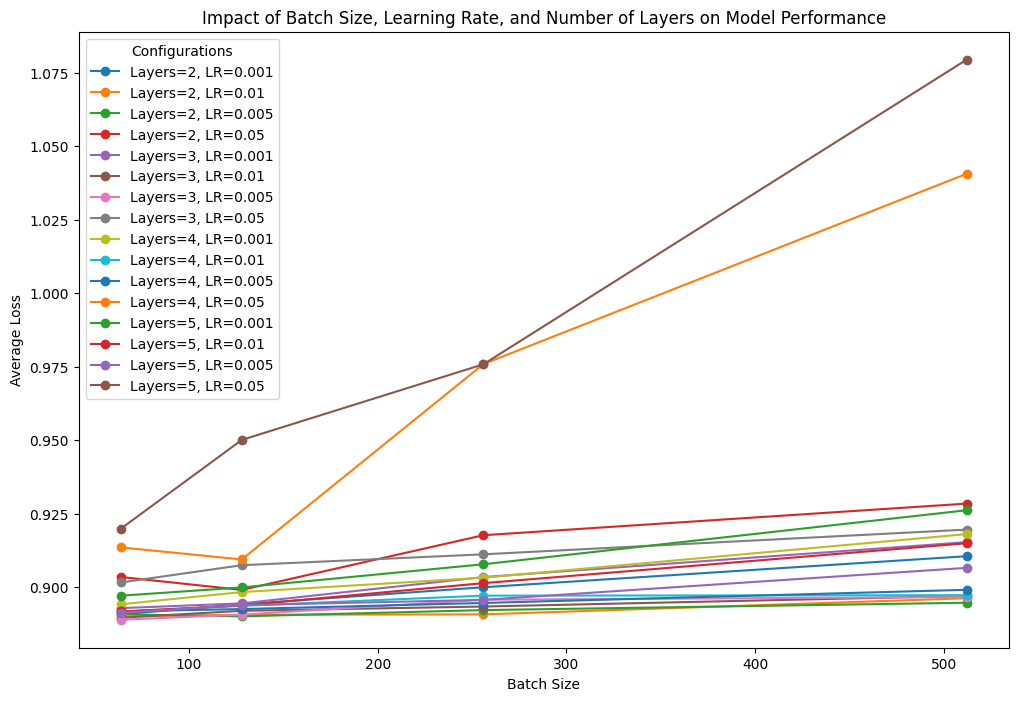

In [ ]:
from tqdm import tqdm
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters to test
batch_sizes = [64, 128, 256, 512]
learning_rates = [0.001, 0.01, 0.005, 0.05]
number_of_layers = [2, 3, 4, 5]
results = []

# Total number of combinations
total_combinations = len(batch_sizes) * len(learning_rates) * len(number_of_layers)

# Outer loop with tqdm for monitoring progress
for batch_size, lr, layers in tqdm(product(batch_sizes, learning_rates, number_of_layers), total=total_combinations, desc="Parameter Combinations"):
    
    # Set up the model and optimizer with current parameters
    model = TimeSeriesForecastingModel_activation(input_size=19, hidden_size=64, num_layers=layers, output_size=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = nn.MSELoss()
    
    # Train the model and record final loss
    epoch_losses = [] 

    for epoch in range(5):
        model.train()
        batch_loss_sum = 0
        
        # Create DataLoader with current batch size
        data_loader = WindowGenerator(
            input_width=24,
            label_width=1,
            shift=1,
            train_df=train_df,
            val_df=val_df,
            test_df=test_df,
            batch_size=batch_size
        ).test
        
        for inputs, targets in data_loader:
            inputs = inputs.squeeze(1)
            targets = targets.squeeze(1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            
            batch_loss_sum += loss.item()
        
        # Calculate and store average loss for this epoch
        epoch_loss = batch_loss_sum / len(data_loader)
        epoch_losses.append(epoch_loss)
    
    # Average loss across epochs for current parameters
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    results.append({'batch_size': batch_size, 'learning_rate': lr, 'number_of_layers': layers, 'avg_loss': avg_loss})
    
    # Print progress for each parameter combination
    print(f"Batch Size: {batch_size}, Learning Rate: {lr}, Layers: {layers}, Avg Loss: {avg_loss:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting results
plt.figure(figsize=(12, 8))
for layers in number_of_layers:
    subset = results_df[results_df['number_of_layers'] == layers]
    for lr in learning_rates:
        subset_lr = subset[subset['learning_rate'] == lr]
        plt.plot(subset_lr['batch_size'], subset_lr['avg_loss'], marker='o', label=f'Layers={layers}, LR={lr}')
        
plt.xlabel('Batch Size')
plt.ylabel('Average Loss')
plt.title('Impact of Batch Size, Learning Rate, and Number of Layers on Model Performance')
plt.legend(title='Configurations')
plt.show()
